In [1]:
# Google Drive를 Colab 환경에 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
id = '1D5yAVPgDcNdZrFzftgLnmOaEd-Swy-GF'
!gdown {id} -O /content/roboflow.zip
!unzip -q /content/roboflow.zip -d /content/emotion

Downloading...
From (original): https://drive.google.com/uc?id=1D5yAVPgDcNdZrFzftgLnmOaEd-Swy-GF
From (redirected): https://drive.google.com/uc?id=1D5yAVPgDcNdZrFzftgLnmOaEd-Swy-GF&confirm=t&uuid=0edeae77-d552-473b-be1b-c6302973a6de
To: /content/roboflow.zip
 44% 1.18G/2.69G [00:11<00:14, 106MB/s] Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gdown/__main__.py", line 172, in main
    download(
  File "/usr/local/lib/python3.12/dist-packages/gdown/download.py", line 369, in download
    f.write(chunk)
KeyboardInterrupt
 44% 1.19G/2.69G [00:12<00:15, 98.5MB/s]
^C
unzip:  cannot find or open /content/roboflow.zip, /content/roboflow.zip.zip or /content/roboflow.zip.ZIP.


In [3]:
#gdown 안될 때
!unzip -q /content/drive/MyDrive/05.share/roboflow.zip -d /content/emotion

# MobileNet 불러오기
- save로 모델 생성
- 이전에 학습했던 가중치 파일 적용

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/02.git/healthcare-hackathon/model/fer2013-finetuning')

In [5]:
import torch
from models.classifier import create_emotion_classifier
from utils.dataset import create_dataloaders
from utils.trainer import EmotionTrainer
from configs.config import Config

# 모델 생성
model = create_emotion_classifier(
    num_classes=Config.NUM_CLASSES,
    backbone_name=Config.MODEL_NAME
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

In [6]:
# 가중치 파일 다운로드(구글드라이브 링크)
file_id = "1eGZ8Kb3jd_V9wYSI7BBgbxKrItcuvGg_"

# gdown을 사용하여 파일 다운로드
!gdown {file_id} -O /content/MobileNet_finetuned.pth

Downloading...
From (original): https://drive.google.com/uc?id=1eGZ8Kb3jd_V9wYSI7BBgbxKrItcuvGg_
From (redirected): https://drive.google.com/uc?id=1eGZ8Kb3jd_V9wYSI7BBgbxKrItcuvGg_&confirm=t&uuid=8f26b090-ac31-44b6-be5f-7b301fa113d6
To: /content/MobileNet_finetuned.pth
100% 37.1M/37.1M [00:00<00:00, 53.5MB/s]


In [7]:
# 저장된 가중치 로드
checkpoint = torch.load('/content/MobileNet_finetuned.pth', map_location=Config.DEVICE)
model.load_state_dict(checkpoint)
print("✅ best_model_copy.pth 로드 완료")

# 모델의 디바이스 확인
model.to(Config.DEVICE)
device = next(model.parameters()).device
print(f"모델은 현재 {device}에 있습니다.")

✅ best_model_copy.pth 로드 완료
모델은 현재 cuda:0에 있습니다.


In [8]:
# Cell 1: 라이브러리 임포트 및 설정 (MobileNet용)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import json
from PIL import Image
import os
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report
import logging
from tqdm.auto import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("라이브러리 임포트 완료")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# MobileNet용 전처리 변환 정의
mobilenet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet 표준 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet 평균
        std=[0.229, 0.224, 0.225]    # ImageNet 표준편차
    )
])

print("✅ MobileNet 전처리 변환 정의 완료")

라이브러리 임포트 완료
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True
✅ MobileNet 전처리 변환 정의 완료


In [9]:
# Cell 2: 데이터셋 클래스 정의
class COCOFaceDatasetMobileNet(Dataset):
    def __init__(self, annotation_file, image_dir, transform, is_train=True):
        print(f"데이터셋 로딩 시작: {annotation_file}")

        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        self.image_dir = image_dir
        self.transform = transform
        self.is_train = is_train

        # categories 정보 확인
        if 'categories' in self.coco_data:
            print("카테고리 정보:")
            for cat in self.coco_data['categories']:
                print(f"  {cat['id']}: {cat['name']}")

        # category_id를 감정으로 매핑
        self.category_to_emotion = {}
        if 'categories' in self.coco_data:
            for cat in self.coco_data['categories']:
                cat_name = cat['name'].lower()
                if 'angry' in cat_name or 'anger' in cat_name:
                    self.category_to_emotion[cat['id']] = 'angry'
                elif 'happy' in cat_name or 'joy' in cat_name:
                    self.category_to_emotion[cat['id']] = 'happy'
                elif 'sad' in cat_name or 'sadness' in cat_name:
                    self.category_to_emotion[cat['id']] = 'sad'
                elif 'neutral' in cat_name:
                    self.category_to_emotion[cat['id']] = 'neutral'
                else:
                    self.category_to_emotion[cat['id']] = 'neutral'

        print(f"카테고리 매핑: {self.category_to_emotion}")

        # ViT와 동일한 감정 매핑
        self.emotion_mapping = {
            'angry': 0,
            'happy': 3,
            'neutral': 4,
            'sad': 5
        }

        print(f"JSON 키: {list(self.coco_data.keys())}")
        print(f"이미지 개수: {len(self.coco_data.get('images', []))}")
        print(f"어노테이션 개수: {len(self.coco_data.get('annotations', []))}")

        self.annotations = self._prepare_annotations()
        print(f"필터링된 어노테이션 개수: {len(self.annotations)}")

    def _prepare_annotations(self):
        annotations = []

        if 'images' not in self.coco_data or 'annotations' not in self.coco_data:
            print(f"경고: JSON에 'images' 또는 'annotations' 키가 없습니다")
            return annotations

        image_info = {img['id']: img for img in self.coco_data['images']}

        for i, ann in enumerate(self.coco_data['annotations']):
            if i == 0:
                print(f"첫 번째 어노테이션 구조: {ann.keys()}")
                print(f"첫 번째 어노테이션 샘플: {ann}")

            category_id = ann.get('category_id', 0)
            emotion = self.category_to_emotion.get(category_id, 'neutral')

            if emotion in self.emotion_mapping:
                image_id = ann['image_id']
                if image_id in image_info:
                    annotations.append({
                        'image_info': image_info[image_id],
                        'bbox': ann['bbox'],
                        'emotion': emotion
                    })

        return annotations

    def _crop_face_with_padding(self, image, bbox):
        """ViT와 동일한 1:1 비율 크롭 + 패딩"""
        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)

        img_h, img_w = image.shape[:2]

        # bbox로 이미지 자름
        x = max(0, x)
        y = max(0, y)
        w = min(w, img_w - x)
        h = min(h, img_h - y)

        cropped = image[y:y+h, x:x+w]

        # 1:1 비율로 패딩
        max_size = max(w, h)
        square_img = np.zeros((max_size, max_size, 3), dtype=np.uint8)

        y_offset = (max_size - h) // 2
        x_offset = (max_size - w) // 2

        square_img[y_offset:y_offset+h, x_offset:x_offset+w] = cropped

        return square_img

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann['image_info']['file_name'])

        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"이미지 로딩 실패: {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # ViT와 동일한 전처리: bbox 크롭 + 1:1 패딩
            face_image = self._crop_face_with_padding(image, ann['bbox'])
            pil_image = Image.fromarray(face_image)

            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')

            if pil_image.size[0] < 10 or pil_image.size[1] < 10:
                pil_image = pil_image.resize((224, 224))

        except Exception as e:
            print(f"이미지 처리 오류 (idx {idx}): {e}")
            pil_image = Image.new('RGB', (224, 224), color=(128, 128, 128))

        # MobileNet용 전처리 적용
        image_tensor = self.transform(pil_image)
        label = self.emotion_mapping[ann['emotion']]

        return {
            'image': image_tensor,
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("MobileNet 데이터셋 클래스 정의 완료")

MobileNet 데이터셋 클래스 정의 완료


In [10]:
# Cell 3: MobileNet 모델 래퍼 클래스 정의
class MobileNetEmotionClassifier(nn.Module):
    def __init__(self, pretrained_model, freeze_backbone=True):
        super().__init__()
        self.mobilenet = pretrained_model

        if freeze_backbone:
            print("MobileNet 백본 동결 중...")
            # 분류기만 제외하고 모든 파라미터 동결
            for name, param in self.mobilenet.named_parameters():
                if 'classifier' not in name and 'fc' not in name:
                    param.requires_grad = False

        print("MobileNet 모델 래퍼 생성 완료")

    def forward(self, x):
        return self.mobilenet(x)

# 기존 모델을 래퍼로 감싸기
mobilenet_model = MobileNetEmotionClassifier(model, freeze_backbone=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenet_model.to(device)

print(f"✅ MobileNet 모델 래퍼 생성 완료")
print(f"사용 디바이스: {device}")

# 모델 파라미터 확인
total_params = sum(p.numel() for p in mobilenet_model.parameters())
trainable_params = sum(p.numel() for p in mobilenet_model.parameters() if p.requires_grad)
print(f"총 파라미터: {total_params:,}")
print(f"학습 가능한 파라미터: {trainable_params:,}")

MobileNet 백본 동결 중...
MobileNet 모델 래퍼 생성 완료
✅ MobileNet 모델 래퍼 생성 완료
사용 디바이스: cuda
총 파라미터: 9,158,231
학습 가능한 파라미터: 723,719


In [11]:
# Cell 4: 데이터셋 로드 및 확인
base_path = '/content/emotion'

# 훈련 데이터셋
train_dataset = COCOFaceDatasetMobileNet(
    annotation_file=os.path.join(base_path, 'train', '_annotations.coco.json'),
    image_dir=os.path.join(base_path, 'train'),
    transform=mobilenet_transforms,
    is_train=True
)
print(f"✅ 훈련 데이터셋 로드 완료: {len(train_dataset)} 샘플")

# 검증 데이터셋
val_dataset = COCOFaceDatasetMobileNet(
    annotation_file=os.path.join(base_path, 'valid', '_annotations.coco.json'),
    image_dir=os.path.join(base_path, 'valid'),
    transform=mobilenet_transforms,
    is_train=False
)
print(f"✅ 검증 데이터셋 로드 완료: {len(val_dataset)} 샘플")

# 감정 분포 확인
train_emotions = [ann['emotion'] for ann in train_dataset.annotations]
val_emotions = [ann['emotion'] for ann in val_dataset.annotations]

from collections import Counter
print(f"\n훈련 데이터 감정 분포: {Counter(train_emotions)}")
print(f"검증 데이터 감정 분포: {Counter(val_emotions)}")


데이터셋 로딩 시작: /content/emotion/train/_annotations.coco.json
카테고리 정보:
  0: face-emotion
  1: angry
  2: happy
  3: neutral
  4: sad
카테고리 매핑: {0: 'neutral', 1: 'angry', 2: 'happy', 3: 'neutral', 4: 'sad'}
JSON 키: ['info', 'licenses', 'categories', 'images', 'annotations']
이미지 개수: 5584
어노테이션 개수: 5592
첫 번째 어노테이션 구조: dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])
첫 번째 어노테이션 샘플: {'id': 0, 'image_id': 0, 'category_id': 3, 'bbox': [806, 427, 647.368, 925.788], 'area': 599325.961, 'segmentation': [], 'iscrowd': 0}
필터링된 어노테이션 개수: 5592
✅ 훈련 데이터셋 로드 완료: 5592 샘플
데이터셋 로딩 시작: /content/emotion/valid/_annotations.coco.json
카테고리 정보:
  0: face-emotion
  1: angry
  2: happy
  3: neutral
  4: sad
카테고리 매핑: {0: 'neutral', 1: 'angry', 2: 'happy', 3: 'neutral', 4: 'sad'}
JSON 키: ['info', 'licenses', 'categories', 'images', 'annotations']
이미지 개수: 1208
어노테이션 개수: 1211
첫 번째 어노테이션 구조: dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])
첫 번째 

In [12]:
# Cell 5: 데이터 로더 생성
if len(train_dataset) > 0 and len(val_dataset) > 0:
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=12,
        pin_memory=True,
        prefetch_factor=4
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=12,
        pin_memory=True,
        prefetch_factor=4
    )
    print(f"✅ 데이터로더 생성 완료")
    print(f"훈련 배치 수: {len(train_loader)}")
    print(f"검증 배치 수: {len(val_loader)}")

    # 첫 번째 배치 테스트
    try:
        first_batch = next(iter(train_loader))
        print(f"첫 번째 배치 확인:")
        print(f"- image 형태: {first_batch['image'].shape}")
        print(f"- labels 형태: {first_batch['labels'].shape}")
        print(f"- labels 값: {first_batch['labels']}")
    except Exception as e:
        print(f"❌ 첫 번째 배치 로드 실패: {e}")
else:
    print("❌ 데이터셋이 비어있어서 데이터로더를 생성할 수 없습니다.")


✅ 데이터로더 생성 완료
훈련 배치 수: 88
검증 배치 수: 19
첫 번째 배치 확인:
- image 형태: torch.Size([64, 3, 224, 224])
- labels 형태: torch.Size([64])
- labels 값: tensor([0, 4, 5, 5, 5, 5, 3, 0, 0, 0, 4, 5, 3, 4, 0, 4, 5, 5, 4, 4, 3, 3, 0, 3,
        3, 0, 0, 5, 5, 4, 5, 0, 5, 4, 3, 3, 0, 0, 5, 3, 4, 0, 3, 4, 3, 4, 5, 5,
        0, 3, 0, 5, 5, 5, 0, 3, 3, 3, 5, 0, 3, 4, 5, 5])


In [13]:
# Cell 6: 훈련 함수 정의
def masked_cross_entropy_loss(outputs, labels, valid_classes=[0, 3, 4, 5]):
    """4개 감정 클래스에 대해서만 손실 계산"""
    mask = torch.zeros_like(labels, dtype=torch.bool)
    for valid_class in valid_classes:
        mask |= (labels == valid_class)

    if mask.sum() == 0:
        return torch.tensor(0.0, requires_grad=True).to(outputs.device)

    masked_outputs = outputs[mask]
    masked_labels = labels[mask]

    criterion = nn.CrossEntropyLoss()
    return criterion(masked_outputs, masked_labels)

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, batch in enumerate(pbar):
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # ViT와 동일한 마스킹된 손실 함수 사용
        loss = masked_cross_entropy_loss(outputs, labels, valid_classes=[0, 3, 4, 5])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산 (4개 클래스에 대해서만)
        with torch.no_grad():
            _, predicted = outputs.max(1)
            valid_mask = torch.zeros_like(labels, dtype=torch.bool)
            for valid_class in [0, 3, 4, 5]:
                valid_mask |= (labels == valid_class)

            if valid_mask.sum() > 0:
                valid_pred = predicted[valid_mask]
                valid_labels = labels[valid_mask]
                total += valid_labels.size(0)
                correct += valid_pred.eq(valid_labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / max(total, 1):.2f}%'
        })

    return total_loss / len(train_loader), 100. * correct / max(total, 1)

def validate_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images)
            loss = masked_cross_entropy_loss(outputs, labels, valid_classes=[0, 3, 4, 5])

            total_loss += loss.item()
            _, predicted = outputs.max(1)

            # 유효한 클래스에 대해서만 정확도 계산
            valid_mask = torch.zeros_like(labels, dtype=torch.bool)
            for valid_class in [0, 3, 4, 5]:
                valid_mask |= (labels == valid_class)

            if valid_mask.sum() > 0:
                valid_pred = predicted[valid_mask]
                valid_labels = labels[valid_mask]
                total += valid_labels.size(0)
                correct += valid_pred.eq(valid_labels).sum().item()

            pbar.set_postfix({
                'Val Loss': f'{loss.item():.4f}',
                'Val Acc': f'{100. * correct / max(total, 1):.2f}%'
            })

    return total_loss / len(val_loader), 100. * correct / max(total, 1)

print("✅ MobileNet 훈련 함수 정의 완료")


✅ MobileNet 훈련 함수 정의 완료


In [14]:
# Cell 7: 훈련 실행
num_epochs = 10
learning_rate = 1e-4

optimizer = optim.AdamW(mobilenet_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_val_acc = 0.0
train_losses = []
val_accuracies = []
training_history = []

print("MobileNet 마스킹된 4개 클래스 훈련 시작...")

# epoch에 tqdm 적용
epoch_pbar = tqdm(range(num_epochs), desc="Epochs")

for epoch in epoch_pbar:
    epoch_desc = f"Epoch {epoch+1}/{num_epochs}"
    epoch_pbar.set_description(epoch_desc)

    # 훈련
    train_loss, train_acc = train_epoch(mobilenet_model, train_loader, optimizer, device)

    # 검증
    val_loss, val_acc = validate_epoch(mobilenet_model, val_loader, device)

    # 스케줄러 업데이트
    scheduler.step()

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    # epoch별 가중치 저장
    model_filename = f'mobilenet_epoch_{epoch+1}.pth'
    torch.save(mobilenet_model.mobilenet.state_dict(), model_filename)  # 래퍼 제거

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(mobilenet_model.mobilenet.state_dict(), 'best_mobilenet_model.pth')  # 래퍼 제거
        save_indicator = "💾 Best!"
    else:
        save_indicator = "💾 Saved"

    # 훈련 이력 기록
    history_record = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': scheduler.get_last_lr()[0],
        'is_best': val_acc == best_val_acc
    }
    training_history.append(history_record)

    # 이력 출력
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    print(f"Model saved as: {model_filename}")
    if val_acc == best_val_acc:
        print("🌟 New best MobileNet model!")
    print("-" * 50)

    # epoch 진행률 업데이트
    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Train Acc': f'{train_acc:.2f}%',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%',
        'Best': f'{best_val_acc:.2f}%',
        'LR': f'{scheduler.get_last_lr()[0]:.2e}',
        'Status': save_indicator
    })

print(f"\n🎉 MobileNet 4개 클래스 마스킹 훈련 완료!")
print(f"최고 검증 정확도: {best_val_acc:.2f}%")
print(f"총 {len(training_history)}개 epoch 모델 저장 완료")

# 훈련 이력 요약 출력
print("\n📊 MobileNet 훈련 이력 요약:")
for record in training_history:
    status = "⭐ BEST" if record['is_best'] else "    "
    print(f"{status} Epoch {record['epoch']}: Train Acc {record['train_acc']:.2f}% | Val Acc {record['val_acc']:.2f}%")


MobileNet 마스킹된 4개 클래스 훈련 시작...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 1.1897 | Train Acc: 57.64%
Val Loss: 0.9315 | Val Acc: 63.83%
Learning Rate: 9.76e-05
Model saved as: mobilenet_epoch_1.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60><function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  
          ^ ^^ ^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^   ^^ 
   File "/usr/lib/p


Epoch 2/10
Train Loss: 0.9096 | Train Acc: 67.17%
Val Loss: 0.7573 | Val Acc: 70.19%
Learning Rate: 9.05e-05
Model saved as: mobilenet_epoch_2.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.7776 | Train Acc: 72.32%
Val Loss: 0.6878 | Val Acc: 73.49%
Learning Rate: 7.94e-05
Model saved as: mobilenet_epoch_3.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.6975 | Train Acc: 75.27%
Val Loss: 0.6240 | Val Acc: 76.80%
Learning Rate: 6.55e-05
Model saved as: mobilenet_epoch_4.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.6380 | Train Acc: 77.56%
Val Loss: 0.6037 | Val Acc: 77.95%
Learning Rate: 5.00e-05
Model saved as: mobilenet_epoch_5.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [02:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in 

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.6027 | Train Acc: 79.01%
Val Loss: 0.5773 | Val Acc: 78.20%
Learning Rate: 3.45e-05
Model saved as: mobilenet_epoch_6.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [04:00<?, ?it/s]


Epoch 7/10
Train Loss: 0.5966 | Train Acc: 79.13%
Val Loss: 0.5673 | Val Acc: 78.78%
Learning Rate: 2.06e-05
Model saved as: mobilenet_epoch_7.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 0.5703 | Train Acc: 79.74%
Val Loss: 0.5563 | Val Acc: 78.94%
Learning Rate: 9.55e-06
Model saved as: mobilenet_epoch_8.pth
🌟 New best MobileNet model!
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1610, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c69f81f9c60>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", l


Epoch 9/10
Train Loss: 0.5587 | Train Acc: 80.04%
Val Loss: 0.5578 | Val Acc: 78.36%
Learning Rate: 2.45e-06
Model saved as: mobilenet_epoch_9.pth
--------------------------------------------------


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 10/10
Train Loss: 0.5638 | Train Acc: 80.78%
Val Loss: 0.5463 | Val Acc: 79.19%
Learning Rate: 0.00e+00
Model saved as: mobilenet_epoch_10.pth
🌟 New best MobileNet model!
--------------------------------------------------

🎉 MobileNet 4개 클래스 마스킹 훈련 완료!
최고 검증 정확도: 79.19%
총 10개 epoch 모델 저장 완료

📊 MobileNet 훈련 이력 요약:
⭐ BEST Epoch 1: Train Acc 57.64% | Val Acc 63.83%
⭐ BEST Epoch 2: Train Acc 67.17% | Val Acc 70.19%
⭐ BEST Epoch 3: Train Acc 72.32% | Val Acc 73.49%
⭐ BEST Epoch 4: Train Acc 75.27% | Val Acc 76.80%
⭐ BEST Epoch 5: Train Acc 77.56% | Val Acc 77.95%
⭐ BEST Epoch 6: Train Acc 79.01% | Val Acc 78.20%
⭐ BEST Epoch 7: Train Acc 79.13% | Val Acc 78.78%
⭐ BEST Epoch 8: Train Acc 79.74% | Val Acc 78.94%
     Epoch 9: Train Acc 80.04% | Val Acc 78.36%
⭐ BEST Epoch 10: Train Acc 80.78% | Val Acc 79.19%


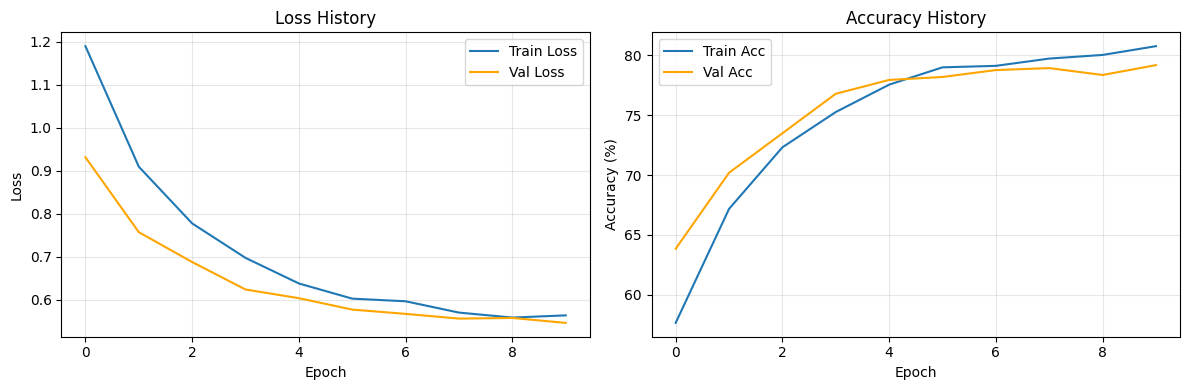

✅ MobileNet 훈련 결과 시각화 완료


In [15]:
# Cell 8: 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot([history['val_loss'] for history in training_history], label='Val Loss', color='orange')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot([history['train_acc'] for history in training_history], label='Train Acc')
plt.plot(val_accuracies, label='Val Acc', color='orange')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ MobileNet 훈련 결과 시각화 완료")
